# Importing Libraries

In [ ]:
import cv2
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers

# Loading the Data

In [ ]:
data_dir = '/content/drive/MyDrive/Tomato Plant'

data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(224,224),
    batch_size=16
)

Found 14612 files belonging to 9 classes.


In [ ]:
class_names = data.class_names
class_names

['Bacterial Spot',
 'Curl Virus',
 'Early Blight',
 'Healthy',
 'Late Blight',
 'Leaf Mold',
 'Mosaic Virus',
 'Septorial Leaf Spot',
 'Two Spotted Spider Mite']

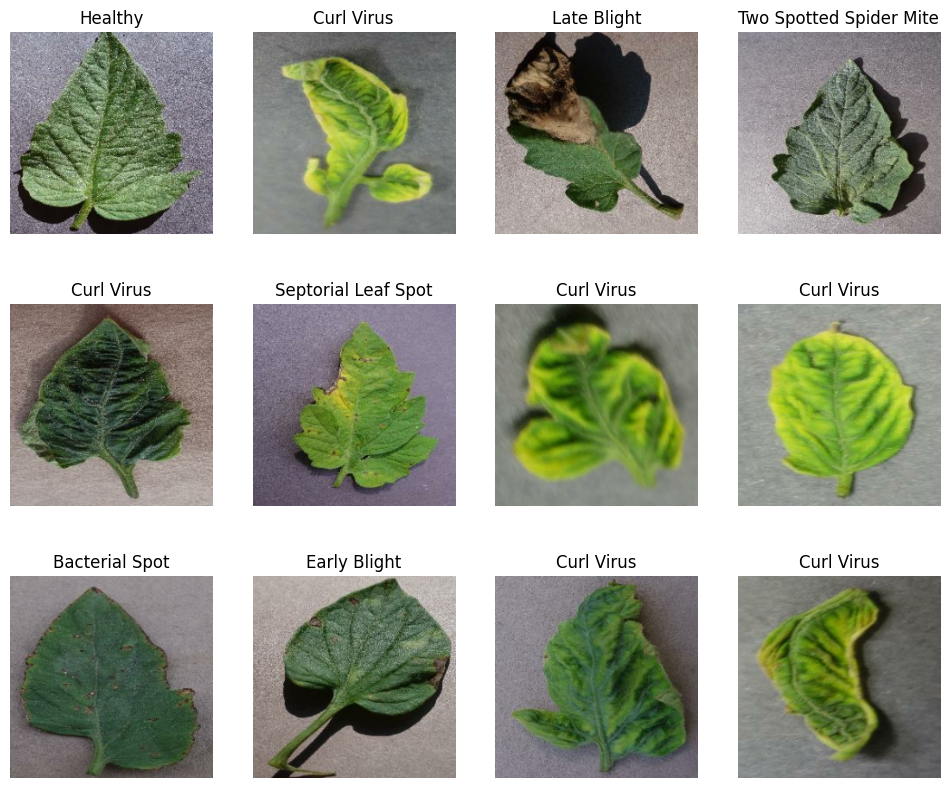

In [ ]:
plt.figure(figsize=(12,10))

for image_batch, label_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

# Partitioning the dataset

In [ ]:
total_batch = len(data)

train_size = int(total_batch*0.7)+1
val_size = int(total_batch*0.2)+1
test_size = int(total_batch*0.1)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Model Building

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  Resizing(256, 256),
  Rescaling(1./255),
])

In [ ]:
model = keras.Sequential([
    # resize_and_rescale,
    resize_and_rescale,
    layers.Conv2D(32, (3,3), 1, activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(18, activation='relu'),
    layers.Dense(9, activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.build(input_shape=(None, 256, 256, 3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 64)       

# Training the model

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
640/640 [==============================] - 396s 598ms/step - loss: 1.5849 - accuracy: 0.4368 - val_loss: 1.1201 - val_accuracy: 0.6274
Epoch 2/20
640/640 [==============================] - 77s 120ms/step - loss: 0.8741 - accuracy: 0.7022 - val_loss: 0.6603 - val_accuracy: 0.7732
Epoch 3/20
640/640 [==============================] - 70s 109ms/step - loss: 0.5410 - accuracy: 0.8190 - val_loss: 0.4738 - val_accuracy: 0.8436
Epoch 4/20
640/640 [==============================] - 76s 119ms/step - loss: 0.3841 - accuracy: 0.8727 - val_loss: 0.3756 - val_accuracy: 0.8770
Epoch 5/20
640/640 [==============================] - 66s 102ms/step - loss: 0.2689 - accuracy: 0.9138 - val_loss: 0.3263 - val_accuracy: 0.8975
Epoch 6/20
640/640 [==============================] - 77s 119ms/step - loss: 0.2347 - accuracy: 0.9215 - val_loss: 0.2724 - val_accuracy: 0.9187
Epoch 7/20
640/640 [==============================] - 79s 123ms/step - loss: 0.1864 - accuracy: 0.9412 - val_loss: 0.2985 - val_a

In [ ]:
scores = model.evaluate(test)

91/91 [==============================] - 64s 402ms/step - loss: 0.4379 - accuracy: 0.9294


# Plotting the model's accuracy

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

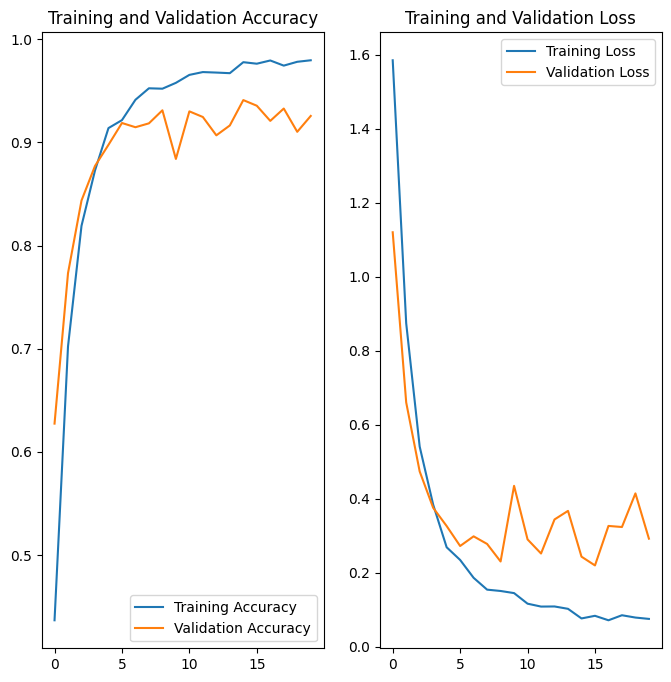

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Plotting the predictions

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


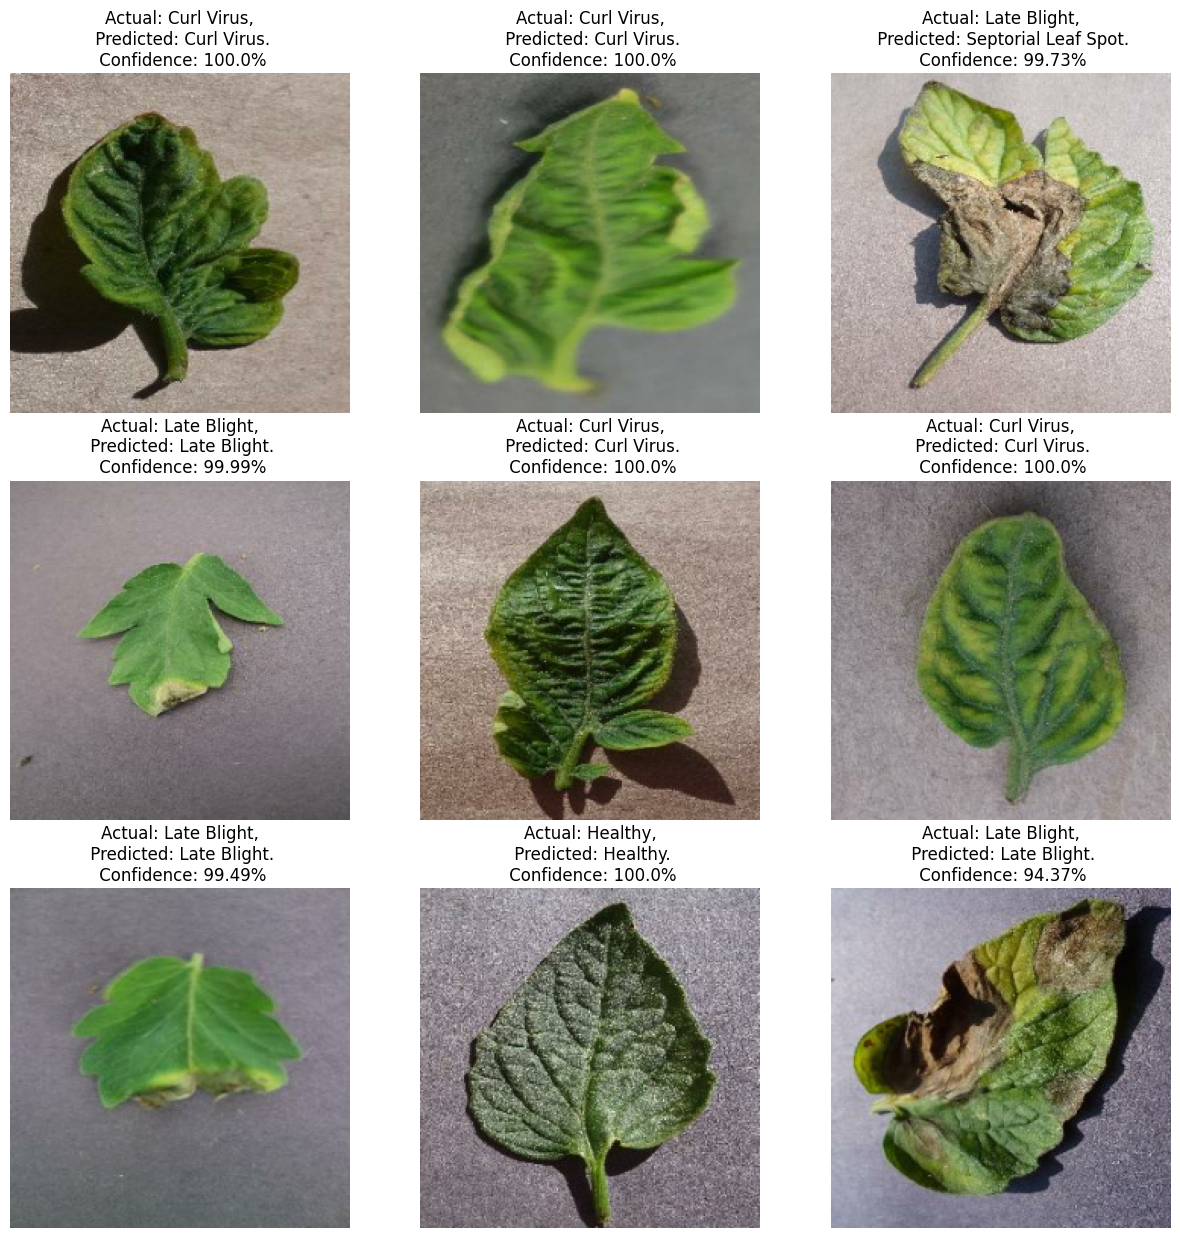

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Saving the model

In [ ]:
model.save("tomato.h5")